In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/Job_Assignment/Ex2'
! ls 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Job_Assignment/Ex2
 dogs-vs-cats.zip
 EX2_DataLoader.ipynb
 kaggle.json
 sampleSubmission.csv
 test1
 train
 Untitled0.ipynb
'Use convolutional neural networks (CNNs) with large datasets to avoid overfitting.ipynb'


In [2]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# **Config**

In [3]:
train_path = 'train'
test_path = 'test1'
val_size = 0.2
batch_size = 32
buffer_size = 1000
class_names = ['cat', 'dog']
image_size = 128
rng = tf.random.Generator.from_seed(123, alg='philox')
AUTOTUNE = tf.data.AUTOTUNE

# **Data Loader**

**Load data from file paths**

In [4]:
def file_paths(train_path, test_path, val_size):
    """Loads dataset from path"""
    train_root = train_path
    train_root = pathlib.Path(train_root)
    list_train = tf.data.Dataset.list_files(str(train_root/'*'))
    #train, validation
    image_count = len(list_train)
    val_size = int(image_count * val_size)
    train_paths = list_train.skip(val_size)
    val_paths = list_train.take(val_size)

    #test
    test_root = test_path
    test_root = pathlib.Path(test_root)
    test_paths = tf.data.Dataset.list_files(str(test_root/'*'))

    return train_paths, val_paths, test_paths

In [5]:
train_paths, val_paths, test_paths = file_paths(train_path, test_path, val_size)

In [6]:
print(tf.data.experimental.cardinality(train_paths).numpy())
print(tf.data.experimental.cardinality(val_paths).numpy())
print(tf.data.experimental.cardinality(test_paths).numpy())

20000
5000
12500


**Get label**

In [7]:
def get_label(file_path, class_names):
    # Convert the path to a list of path components
    file = tf.strings.split(file_path, os.sep)[1]
    label = tf.strings.split(file,'.')[0]
    one_hot = label == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

In [8]:
iterator = iter(train_paths)
label = get_label(iterator.get_next(), class_names)
print(label)

tf.Tensor(0, shape=(), dtype=int64)


**Decode Img**

In [9]:
def decode_img(image,image_size):
    image = tf.io.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, [image_size, image_size])
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    return image

**Process path**

In [10]:
def process_path(file_path,class_names,image_size):
    label = get_label(file_path, class_names)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img, image_size)
    return img, label

In [11]:
def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(class_names[label])
  plt.axis('off')

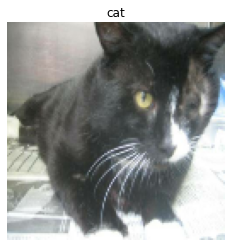

In [12]:
img, label = process_path(iterator.get_next(), class_names,image_size)
show(img, label)

**Augmentation for Train dataset**

 They require a **seed** value be input each step. Given the same seed, they return the **same results** independent of how many times they are called.

In [13]:
def augment(file_path, class_names, image_size, seed):
    image, label = process_path(file_path,class_names,image_size)
    # Crops and/or pads an image to a target width and height.
    image = tf.image.resize_with_crop_or_pad(image, image_size + 6, image_size + 6)
    # Random crop back to the original size.
    image = tf.image.stateless_random_crop(
    image, size=[image_size, image_size, 3], seed=seed)
    # Random brightness.
    image = tf.image.stateless_random_brightness(
    image, max_delta=0.4, seed=seed)
    # Clips tensor values to a specified min(0) and max(1).
    image = tf.clip_by_value(image, 0, 1)
    return image, label

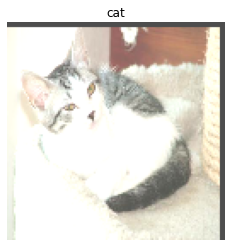

In [14]:
img, label = augment(iterator.get_next(), class_names,image_size, seed = (1,0))
show(img, label)

* Create a **tf.random.Generator** object with an initial seed value

* Passes the newly **generated seed** value into the augment function for random transformations



In [15]:
def f(file_path, class_names, image_size, rng):
    seed = rng.make_seeds(2)[0]
    image, label = augment(file_path, class_names, image_size, seed)
    return image, label

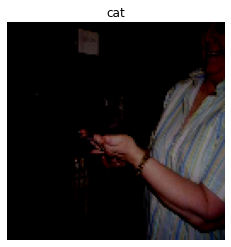

In [16]:
img, label = f(iterator.get_next(), class_names,image_size, rng)
show(img, label)

**Prepare Data Generator**

In [17]:
def configure_for_performance(ds, batch_size, buffer_size, class_names, image_size, rng, AUTOTUNE, training = False):
    if training:
        ds = ds.shuffle(buffer_size)
        # Resize and rescale all datasets.
        ds = ds.map(lambda ds: f(ds,class_names, image_size, rng),
                    num_parallel_calls=AUTOTUNE)
        # Batch all datasets.
        ds = ds.batch(batch_size)
    else:
        ds = ds.map(lambda ds: process_path(ds,class_names,image_size),
                    num_parallel_calls=AUTOTUNE)
        # Batch all datasets.
        ds = ds.batch(batch_size)

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

In [18]:
train_ds = configure_for_performance(train_paths, batch_size, buffer_size, class_names, image_size, rng, AUTOTUNE, training = True)
val_ds = configure_for_performance(val_paths, batch_size, buffer_size, class_names, image_size, rng, AUTOTUNE, training = False)
test_ds = configure_for_performance(test_paths, batch_size, buffer_size, class_names, image_size, rng, AUTOTUNE, training = False)

# **Samples**

In [19]:
def show_batch(batch,title = None):
    ax = plt.figure(figsize=(10,20))
    ax.suptitle(title)
    for i in range(0, batch_size):
        # grab the image and label from the batch
        (image, label) = (batch[0][i], batch[1][i])
        # create a subplot and plot the image and label
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(image.numpy())
        plt.title(class_names[label])
        plt.axis("off") 

X_train:  (32, 128, 128, 3)
y_train (32,)
Image shape:  (128, 128, 3)
Label tf.Tensor(1, shape=(), dtype=int64)


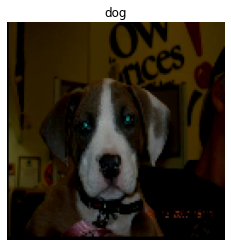

In [20]:
train_iterator = iter(train_ds)
val_iterator = iter(val_ds)
test_iterator = iter(test_ds)


sample = train_iterator.get_next()
print('X_train: ', sample[0].shape)
print('y_train', sample[1].shape)
image = sample[0][0]
print('Image shape: ', image.shape)
label = sample[1][0]
print('Label', label)
show(image, label)

**Training Batch**

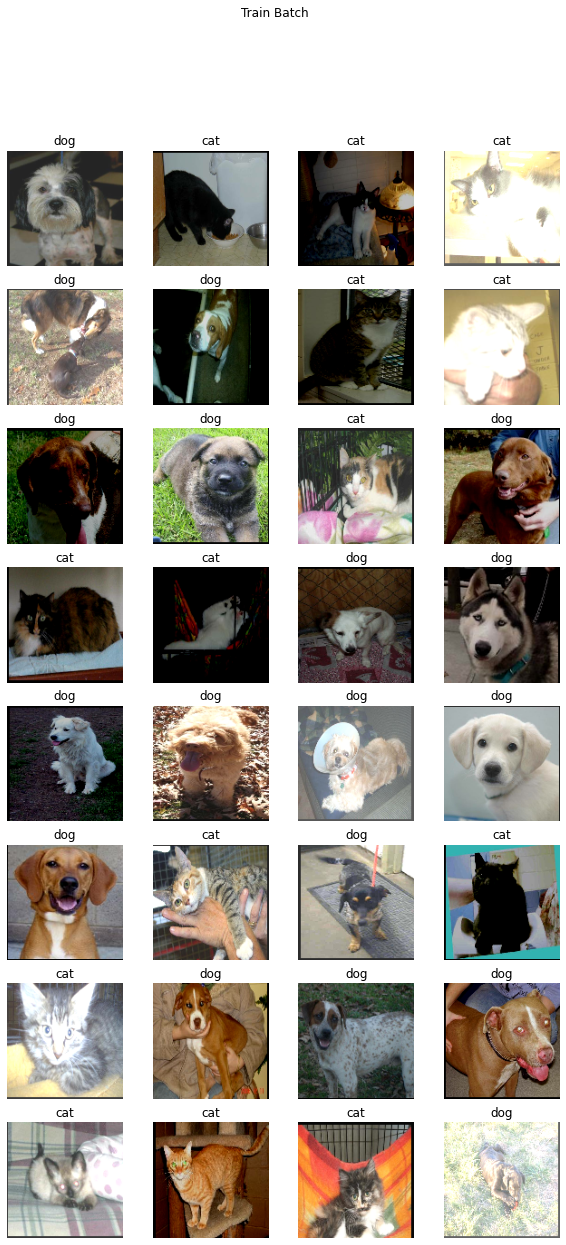

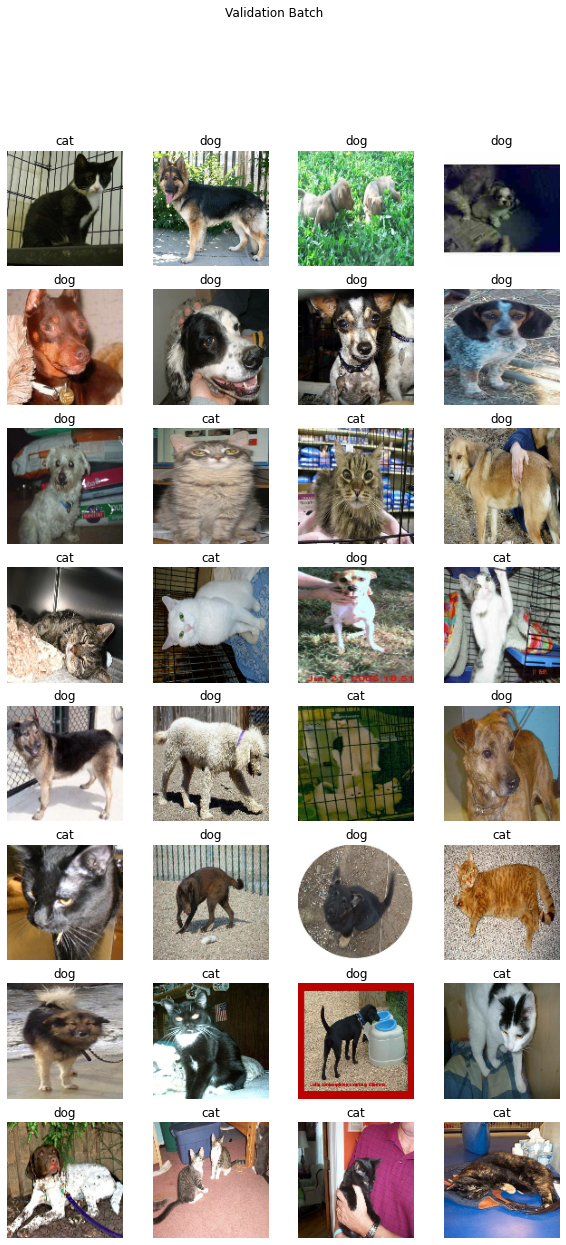

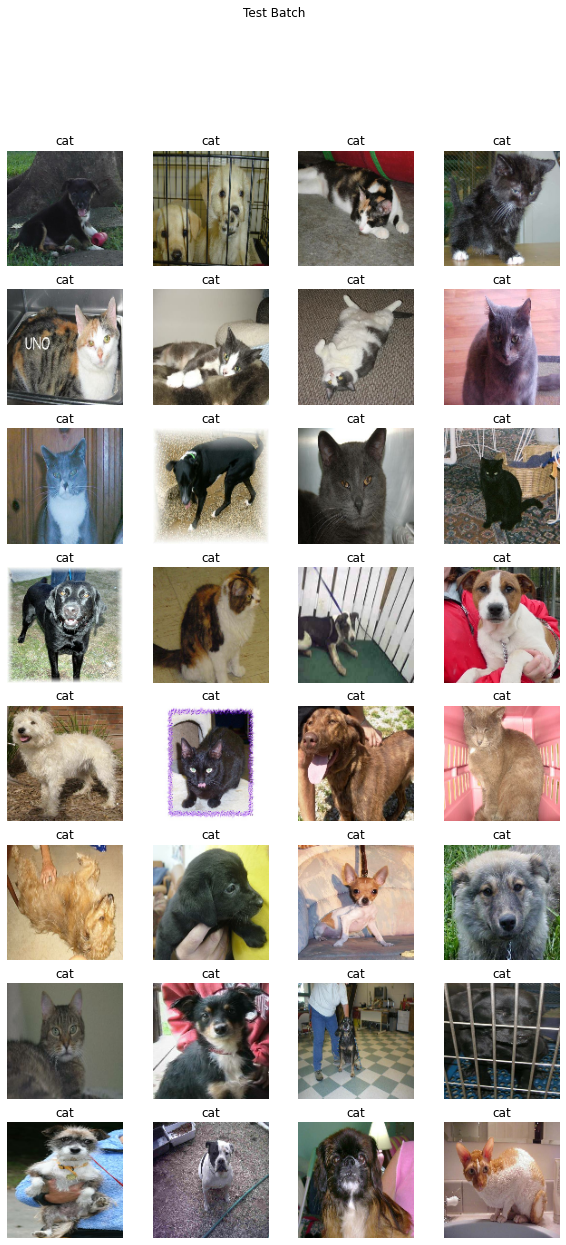

In [21]:
show_batch(train_iterator.get_next(),'Train Batch')
show_batch(val_iterator.get_next(), 'Validation Batch')
show_batch(test_iterator.get_next(), 'Test Batch')